## Step 1: Download Data from TFL 

In [1]:
import os
import requests
from tqdm import tqdm
from datetime import datetime, timedelta

BASE_URL = "https://cycling.data.tfl.gov.uk/usage-stats/"
TARGET_DIR = "tfl_cycle_data"
START_DATE = datetime(2020, 12, 30)
END_DATE = datetime(2023, 6, 19)  # Just before 375
START_INDEX = 246

os.makedirs(TARGET_DIR, exist_ok=True)

def format_date(d):
    return d.strftime("%d%b%Y")

current_date = START_DATE
file_index = START_INDEX
download_links = []

# === PHASE 1: Weekly files (246 to 374, with exceptions)
while current_date < END_DATE:
    # Special case for 334 (5-day file)
    if file_index == 334:
        filename = f"{file_index}JourneyDataExtract07Sep2022-11Sep2022.csv"
        download_links.append((BASE_URL + filename, filename))
        current_date = datetime(2022, 9, 12)
        file_index += 1
        continue

    # Normal 7-day range
    start_str = format_date(current_date)
    end_str = format_date(current_date + timedelta(days=6))
    filename = f"{file_index}JourneyDataExtract{start_str}-{end_str}.csv"
    download_links.append((BASE_URL + filename, filename))
    current_date += timedelta(days=7)
    file_index += 1

# Add special case for 375 (12-day file)
download_links.append((
    BASE_URL + "375JourneyDataExtract19Jun2023-30Jun2023.csv",
    "375JourneyDataExtract19Jun2023-30Jun2023.csv"
))

# === PHASE 2: Manually define filenames from 376 onwards 
manual_files = [
    "376JourneyDataExtract01Jul2023-14Jul2023.csv",
    "377JourneyDataExtract15Jul2023-31Jul2023.csv",
    "378JourneyDataExtract01Aug2023-14Aug2023.csv",
    "378JourneyDataExtract15Aug2023-31Aug2023.csv",
    "379JourneyDataExtract01Sep2023-14Sep2023.csv",
    "380JourneyDataExtract15Sep2023-30Sep2023.csv",
    "381JourneyDataExtract01Oct2023-14Oct2023.csv",
    "382JourneyDataExtract15Oct2023-31Oct2023.csv",
    "383JourneyDataExtract01Nov2023-14Nov2023.csv",
    "384JourneyDataExtract15Nov2023-30Nov2023.csv",
    "385JourneyDataExtract01Dec2023-14Dec2023.csv",
    "386JourneyDataExtract15Dec2023-31Dec2023.csv",
    "387JourneyDataExtract01Jan2024-14Jan2024.csv",
    "388JourneyDataExtract15Jan2024-31Jan2024.csv"
]

for file in manual_files:
    download_links.append((BASE_URL + file, file))

# === DOWNLOAD BLOCK
print(f"Attempting to download {len(download_links)} files...")

for url, filename in tqdm(download_links):
    path = os.path.join(TARGET_DIR, filename)
    if os.path.exists(path):
        continue
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception as e:
        print(f"❌ Failed to download {filename}: {e}")

print("✅ All available files downloaded to:", TARGET_DIR)


Attempting to download 144 files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:16<00:00,  1.88it/s]

✅ All available files downloaded to: tfl_cycle_data


In [2]:
import os
import pandas as pd

# Path to your downloaded CSVs
data_dir = "tfl_cycle_data"

# Get all .csv files
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

# Combine them into one DataFrame
combined_df = pd.DataFrame()
for file in csv_files:
    path = os.path.join(data_dir, file)
    try:
        df = pd.read_csv(path , low_memory=False)
        df["source_file"] = file  # Track file of origin
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Save combined file (optional)
combined_df.to_csv("combined_tfl_cycle_data.csv", index=False)
print("✅ Combined CSV saved as combined_tfl_cycle_data.csv")


✅ Combined CSV saved as combined_tfl_cycle_data.csv


## Step 2: Data Preprocessing

In [3]:
import pandas as pd 

combined_df = pd.read_csv("combined_tfl_cycle_data.csv", low_memory=False)

combined_df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,source_file,...,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,109096951.0,540.0,13318.0,15/06/2021 20:19,661.0,"All Saints Church, Portobello",15/06/2021 20:10,105.0,"Westbourne Grove, Bayswater",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,108982015.0,780.0,18991.0,13/06/2021 13:03,312.0,"Grove End Road, St. John's Wood",13/06/2021 12:50,106.0,"Woodstock Street, Mayfair",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,108839141.0,840.0,16736.0,10/06/2021 15:28,333.0,"Palace Gardens Terrace, Notting Hill",10/06/2021 15:14,106.0,"Woodstock Street, Mayfair",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,108816591.0,1380.0,913.0,09/06/2021 22:37,51.0,"Finsbury Library , Finsbury",09/06/2021 22:14,123.0,"St. John Street, Finsbury",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,108919084.0,1200.0,6682.0,12/06/2021 11:29,732.0,"Duke Street Hill, London Bridge",12/06/2021 11:09,123.0,"St. John Street, Finsbury",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Checking the columns present in dataframe
combined_df.columns

Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name',
       'source_file', 'Number', 'Start date', 'Start station number',
       'Start station', 'End date', 'End station number', 'End station',
       'Bike number', 'Bike model', 'Total duration', 'Total duration (ms)'],
      dtype='object')

In [5]:
# Loop over each column and print unique sample values to see how each columns looks like. 
for col in combined_df.columns:
    print(f"\n📌 Column: {col}")
    print("-" * (10 + len(col)))
    try:
        # Display data type and number of unique values
        print(f"Type: {combined_df[col].dtype}")
        print(f"Unique values: {combined_df[col].nunique()}")
        
        # Show sample unique values (up to 10)
        sample_values = combined_df[col].dropna().unique()[:10]
        for val in sample_values:
            print(f"  - {val}")
    except Exception as e:
        print(f"⚠️ Error processing column '{col}': {e}")



📌 Column: Rental Id
-------------------
Type: float64
Unique values: 19727277
  - 109096951.0
  - 108982015.0
  - 108839141.0
  - 108816591.0
  - 108919084.0
  - 108862447.0
  - 108989560.0
  - 109044915.0
  - 109044901.0
  - 108794152.0

📌 Column: Duration
------------------
Type: float64
Unique values: 4494
  - 540.0
  - 780.0
  - 840.0
  - 1380.0
  - 1200.0
  - 300.0
  - 960.0
  - 360.0
  - 720.0
  - 1020.0

📌 Column: Bike Id
-----------------
Type: float64
Unique values: 17033
  - 13318.0
  - 18991.0
  - 16736.0
  - 913.0
  - 6682.0
  - 2046.0
  - 15460.0
  - 19982.0
  - 17193.0
  - 4211.0

📌 Column: End Date
------------------
Type: object
Unique values: 838859
  - 15/06/2021 20:19
  - 13/06/2021 13:03
  - 10/06/2021 15:28
  - 09/06/2021 22:37
  - 12/06/2021 11:29
  - 10/06/2021 22:38
  - 13/06/2021 15:04
  - 14/06/2021 18:19
  - 09/06/2021 16:12
  - 14/06/2021 18:18

📌 Column: EndStation Id
-----------------------
Type: float64
Unique values: 805
  - 661.0
  - 312.0
  - 333.0
  

In [6]:
# Based on the above output - Few columns can be combined - Doing that
import pandas as pd

# 1. Start by combining duplicate/alternate columns
combined_df['Rental Id'] = combined_df['Rental Id'].combine_first(combined_df['Number'])
combined_df['Bike Id'] = combined_df['Bike Id'].combine_first(combined_df['Bike number'])
combined_df['Start Date'] = combined_df['Start Date'].combine_first(combined_df['Start date'])
combined_df['End Date'] = combined_df['End Date'].combine_first(combined_df['End date'])
combined_df['StartStation Id'] = combined_df['StartStation Id'].combine_first(combined_df['Start station number'])
combined_df['StartStation Name'] = combined_df['StartStation Name'].combine_first(combined_df['Start station'])
combined_df['EndStation Id'] = combined_df['EndStation Id'].combine_first(combined_df['End station number'])
combined_df['EndStation Name'] = combined_df['EndStation Name'].combine_first(combined_df['End station'])

# 2. Convert datetime columns to proper format
combined_df['Start Date'] = pd.to_datetime(combined_df['Start Date'], errors='coerce', dayfirst=True)
combined_df['End Date'] = pd.to_datetime(combined_df['End Date'], errors='coerce', dayfirst=True)

# 3. Create a new cleaned DataFrame with only relevant columns
cleaned_df = combined_df[[
    'Rental Id',
    'Start Date',
    'End Date',
    'Duration',                 # Duration in seconds
    'Bike Id',
    'StartStation Id',
    'StartStation Name',
    'EndStation Id',
    'EndStation Name',
    'Bike model',              
    'source_file'              # To track source if needed
]].copy()

# 4. Rename columns for clarity (camel case or snake case)
cleaned_df.rename(columns={
    'Rental Id': 'rental_id',
    'Start Date': 'start_time',
    'End Date': 'end_time',
    'Duration': 'duration_sec',
    'Bike Id': 'bike_id',
    'StartStation Id': 'start_station_id',
    'StartStation Name': 'start_station_name',
    'EndStation Id': 'end_station_id',
    'EndStation Name': 'end_station_name',
    'Bike model': 'bike_model',
    'source_file': 'source_file'
}, inplace=True)


cleaned_df.reset_index(drop=True, inplace=True)


In [7]:
cleaned_df.head()

,rental_id,start_time,end_time,duration_sec,bike_id,start_station_id,start_station_name,end_station_id,end_station_name,bike_model,source_file
0,109096951.0,2021-06-15 20:10:00,2021-06-15 20:19:00,540.0,13318.0,105.0,"Westbourne Grove, Bayswater",661.0,"All Saints Church, Portobello",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
1,108982015.0,2021-06-13 12:50:00,2021-06-13 13:03:00,780.0,18991.0,106.0,"Woodstock Street, Mayfair",312.0,"Grove End Road, St. John's Wood",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
2,108839141.0,2021-06-10 15:14:00,2021-06-10 15:28:00,840.0,16736.0,106.0,"Woodstock Street, Mayfair",333.0,"Palace Gardens Terrace, Notting Hill",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
3,108816591.0,2021-06-09 22:14:00,2021-06-09 22:37:00,1380.0,913.0,123.0,"St. John Street, Finsbury",51.0,"Finsbury Library , Finsbury",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
4,108919084.0,2021-06-12 11:09:00,2021-06-12 11:29:00,1200.0,6682.0,123.0,"St. John Street, Finsbury",732.0,"Duke Street Hill, London Bridge",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv


In [8]:
# Define the date range
start_date = pd.Timestamp("2021-01-01")
end_date = pd.Timestamp("2023-12-31 23:59:59")

# Filter rows where start_time is within the desired date range
filtered_df = cleaned_df[
    (cleaned_df['start_time'] >= start_date) &
    (cleaned_df['start_time'] <= end_date)
].copy()

filtered_df.to_csv('tfl_cycle_rentals_2021_2023_cleaned.csv')

## Exploratory data analysis

/tmp/ipykernel_275675/2135559314.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette='viridis')
/tmp/ipykernel_275675/2135559314.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='coolwarm')


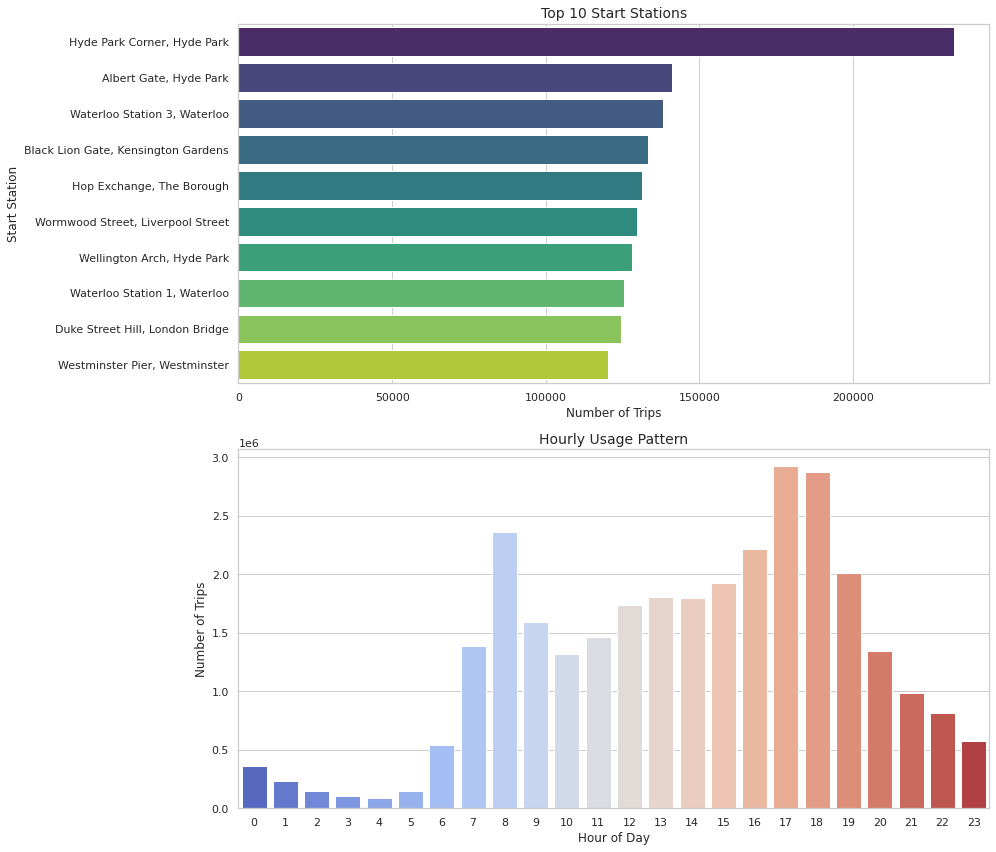

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating additional columns for EDA
filtered_df['duration_min'] = filtered_df['duration_sec'] / 60
filtered_df['hour'] = filtered_df['start_time'].dt.hour
filtered_df['month'] = filtered_df['start_time'].dt.to_period("M").astype(str)  # format: 'YYYY-MM'

sns.set(style="whitegrid")
plt.figure(figsize=(14, 12))  # Adjusted height for 2 plots

# 1. Top 10 Start Stations
plt.subplot(2, 1, 1)
top_start_stations = filtered_df['start_station_name'].value_counts().head(10)
sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette='viridis')
plt.title("Top 10 Start Stations", fontsize=14)
plt.xlabel("Number of Trips")
plt.ylabel("Start Station")

# 2. Hourly Usage Pattern
plt.subplot(2, 1, 2)
hourly_trips = filtered_df.groupby('hour').size().reset_index(name='trip_count')
sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='coolwarm')
plt.title("Hourly Usage Pattern", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")

plt.tight_layout()
plt.show()


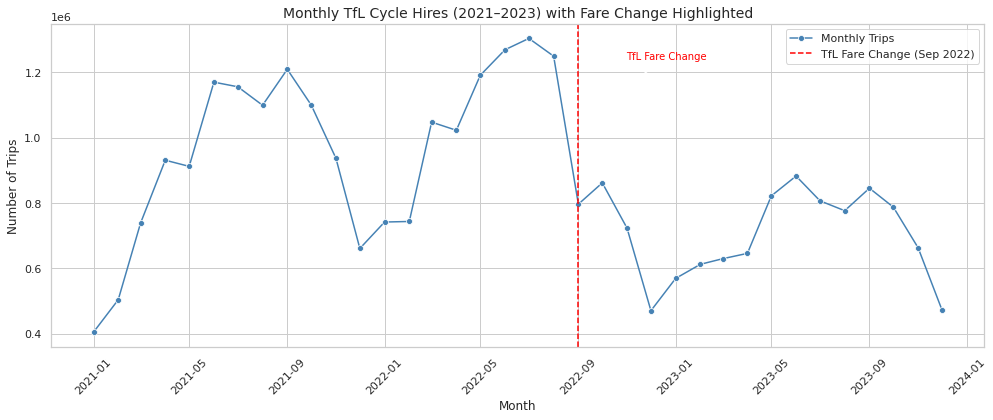

In [15]:
# 3. Generating Plot for Monthly TfL Cycle Hires (2021–2023)

# 1. Ensure 'month' column exists
filtered_df['month'] = pd.to_datetime(filtered_df['start_time']).dt.to_period('M')
monthly_trips = filtered_df.groupby('month').size().reset_index(name='trip_count')
monthly_trips['month'] = monthly_trips['month'].dt.to_timestamp()

# 2. Define the fare change month
fare_change_month = pd.to_datetime("2022-09")

# 3. Plot with annotation
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trips, x='month', y='trip_count', marker='o', color='steelblue', label="Monthly Trips")

# Vertical line for fare change
plt.axvline(fare_change_month, color='red', linestyle='--', linewidth=1.5, label='TfL Fare Change (Sep 2022)')

# Annotation with arrow
plt.annotate(
    'TfL Fare Change', 
    xy=(fare_change_month, monthly_trips['trip_count'].max()*0.8),
    xytext=(fare_change_month + pd.DateOffset(days=60), monthly_trips['trip_count'].max()*0.95),
    arrowprops=dict(facecolor='red', arrowstyle='->', linewidth=1.5),
    color='red',
    fontsize=10
)

# Final formatting
plt.title("Monthly TfL Cycle Hires (2021–2023) with Fare Change Highlighted", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


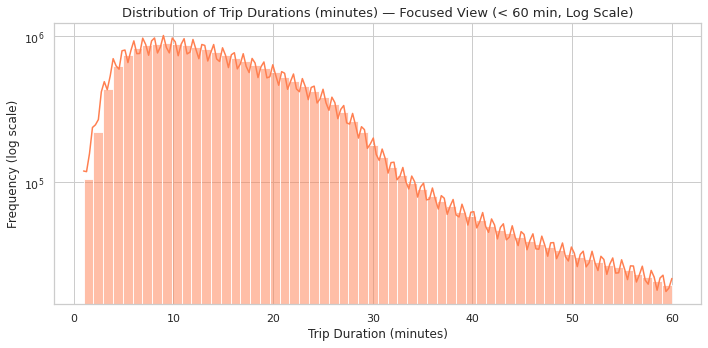

In [18]:
# 4. Distribution of Cycle Trip Durations (minutes) - TfL

# Filter: Keep trips ≤ 60 minutes
duration_cutoff = 60
filtered_subset = filtered_df[filtered_df['duration_min'] <= duration_cutoff]

# Plot: Histogram with better binning and log scale on y-axis
plt.figure(figsize=(10, 5))
sns.histplot(
    data=filtered_subset,
    x='duration_min',
    bins=60,            # One bin per minute
    kde=True,
    color='coral'
)

plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title("Distribution of Trip Durations (minutes) — Focused View (< 60 min, Log Scale)", fontsize=13)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_275675/373495716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='day', order=day_order, palette='Set2')


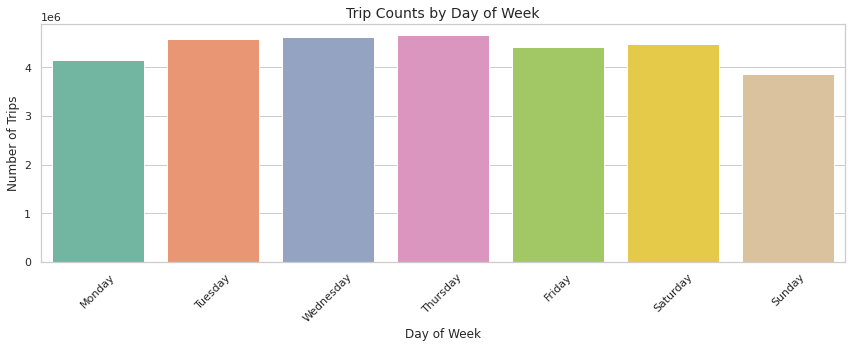

In [21]:
# 5. Day-of-Week Usage 
plt.figure(figsize=(12, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=filtered_df, x='day', order=day_order, palette='Set2')
plt.title("Trip Counts by Day of Week", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Use-Case 1: Station Demand forecasting

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === Step 0: Initialize Progress Bar ===
tqdm.pandas()
filtered_df= pd.read_csv('tfl_cycle_rentals_2021_2023_cleaned.csv', low_memory=False)

# === Step 1: Feature Engineering ===
print("🔧 Extracting features...")
filtered_df['duration_min'] = filtered_df['duration_sec'] / 60
filtered_df['hour'] = filtered_df['start_time'].dt.hour
filtered_df['day_of_week'] = filtered_df['start_time'].dt.dayofweek
filtered_df['bike_model_encoded'] = filtered_df['bike_model'].map({'CLASSIC': 0, 'PBSC_EBIKE': 1})

# === Step 2: Data-Driven Labeling (Top 10% Stations by Usage) ===
print("🏷️ Labeling high-demand stations using 90th percentile...")

station_counts = filtered_df['start_station_name'].value_counts()
threshold = station_counts.quantile(0.90)
high_demand_stations = station_counts[station_counts >= threshold].index

filtered_df['is_high_demand_station'] = filtered_df['start_station_name'].isin(high_demand_stations).astype(int)

# === Step 3: Prepare Training Data ===
print("📦 Preparing training dataset...")

features = ['hour', 'day_of_week', 'duration_min', 'bike_model_encoded']
X = filtered_df[features].fillna(0)
y = filtered_df['is_high_demand_station']

# === Step 4: Train-Test Split ===
print("✂️ Splitting train and test data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Train Model ===
print("🧠 Training Random Forest model...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# === Step 6: Evaluate Model ===
print("📊 Evaluating model...")
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === Step 7: Confusion Matrix ===
print("📉 Generating confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Step 8: Feature Importance Plot ===
print("🪄 Visualizing feature importance...")
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest')
plt.title("Feature Importance - Random Forest Classifier")
plt.tight_layout()
plt.show()

print("✅ Done.")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

🔧 Extracting features...
🏷️ Labeling high-demand stations using 90th percentile...
📦 Preparing training data...
✂️ Splitting dataset...
⚖️ Using scale_pos_weight = 3.22 to balance classes.
🚀 Training XGBoost on GPU with class weight...


/user/HS401/dr00732/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:13:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/user/HS401/dr00732/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:13:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Evaluation Results:


/user/HS401/dr00732/.local/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [05:13:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


              precision    recall  f1-score   support

           0       0.79      0.58      0.67   4692642
           1       0.28      0.51      0.36   1458366

    accuracy                           0.56   6151008
   macro avg       0.53      0.55      0.51   6151008
weighted avg       0.67      0.56      0.60   6151008



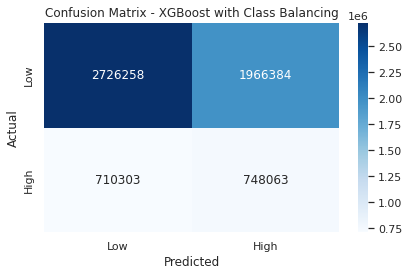

/tmp/ipykernel_275675/2284739636.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Importance', y='Feature', palette='crest')


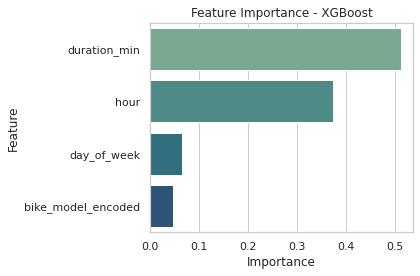

✅ Model training and evaluation completed successfully.


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# === Step 0: Progress Bar Init ===
tqdm.pandas()

# === Step 1: Feature Engineering ===
print("🔧 Extracting features...")
filtered_df['duration_min'] = filtered_df['duration_sec'] / 60
filtered_df['hour'] = filtered_df['start_time'].dt.hour
filtered_df['day_of_week'] = filtered_df['start_time'].dt.dayofweek
filtered_df['bike_model_encoded'] = filtered_df['bike_model'].map({'CLASSIC': 0, 'PBSC_EBIKE': 1})

# === Step 2: Label High-Demand Stations (90th Percentile) ===
print("🏷️ Labeling high-demand stations using 90th percentile...")
station_counts = filtered_df['start_station_name'].value_counts()
threshold = station_counts.quantile(0.90)
high_demand_stations = station_counts[station_counts >= threshold].index
filtered_df['is_high_demand_station'] = filtered_df['start_station_name'].isin(high_demand_stations).astype(int)

# === Step 3: Prepare Features and Labels ===
print("📦 Preparing training data...")
features = ['hour', 'day_of_week', 'duration_min', 'bike_model_encoded']
X = filtered_df[features].fillna(0)
y = filtered_df['is_high_demand_station']

# === Step 4: Train/Test Split ===
print("✂️ Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Calculate Class Imbalance Weight ===
neg, pos = y_train.value_counts()
scale = neg / pos
print(f"⚖️ Using scale_pos_weight = {scale:.2f} to balance classes.")

# === Step 6: Train XGBoost Classifier (with GPU + imbalance handling) ===
print("🚀 Training XGBoost on GPU with class weight...")
model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale
)
model.fit(X_train, y_train)

# === Step 7: Evaluate ===
print("📊 Evaluation Results:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# === Step 8: Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Confusion Matrix - XGBoost with Class Balancing")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Step 9: Feature Importance ===
feature_importance = model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=feature_df, x='Importance', y='Feature', palette='crest')
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

print("✅ Model training and evaluation completed successfully.")


In [31]:
pip install --user --force-reinstall --no-cache-dir imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 117.3 MB/s eta 0:00:001m124.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 117.4 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 158.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 117.0 MB/s eta 0:00:001m117.4 MB/s eta 0:00:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.5.0
    Uninstalling threadpoolctl-3.5.0:
      Successfully uninstalled threadpoolctl-3.5.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: scipy
    Found exis

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# === Step 0: Setup
tqdm.pandas()

# === Step 1: Feature Engineering
print("🔧 Extracting features...")
filtered_df['duration_min'] = filtered_df['duration_sec'] / 60
filtered_df['hour'] = filtered_df['start_time'].dt.hour
filtered_df['day_of_week'] = filtered_df['start_time'].dt.dayofweek
filtered_df['bike_model_encoded'] = filtered_df['bike_model'].map({'CLASSIC': 0, 'PBSC_EBIKE': 1})

# === Step 2: Label High-Demand Stations using 90th percentile
print("🏷️ Labeling high-demand stations...")
station_counts = filtered_df['start_station_name'].value_counts()
threshold = station_counts.quantile(0.90)
high_demand_stations = station_counts[station_counts >= threshold].index
filtered_df['is_high_demand_station'] = filtered_df['start_station_name'].isin(high_demand_stations).astype(int)

# === Step 3: Define full feature set
full_features = ['hour', 'day_of_week', 'duration_min', 'bike_model_encoded']
X_full = filtered_df[full_features].fillna(0)
y = filtered_df['is_high_demand_station']

# === Step 4: Train/Test Split
print("✂️ Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Initial XGBoost for Feature Importance
print("📊 Getting top features...")
xgb_temp = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_temp.fit(X_train, y_train)

# Get top N features by importance (optional: threshold-based)
feature_importance = xgb_temp.feature_importances_
feature_df = pd.DataFrame({'Feature': full_features, 'Importance': feature_importance})
top_features = feature_df.sort_values(by='Importance', ascending=False)['Feature'].head(3).tolist()

print(f"✅ Selected Top Features: {top_features}")

# === Step 6: Apply SMOTE on Training Data (using top features only)
print("🔄 Applying SMOTE to rebalance classes...")
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# === Step 7: Train Final XGBoost Model on Balanced Data
print("🚀 Training XGBoost on GPU with top features + SMOTE...")
model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_resampled, y_train_resampled)

# === Step 8: Evaluation
print("📈 Evaluating performance on test set...")
y_pred = model.predict(X_test_selected)
print(classification_report(y_test, y_pred))

# === Step 9: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Confusion Matrix - Top Features + SMOTE + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Step 10: Feature Importance (Final Model)
final_importance = model.feature_importances_
final_feat_df = pd.DataFrame({'Feature': top_features, 'Importance': final_importance}).sort_values(by='Importance', ascending=False)

sns.barplot(data=final_feat_df, x='Importance', y='Feature', palette='viridis')
plt.title("Final Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

print("✅ Model training and evaluation complete.")


ModuleNotFoundError: No module named 'imblearn'